<a href="https://colab.research.google.com/github/GamaLab42/Material_EQE_441/blob/main/C%C3%A1lculo_de_densidade_de_cargas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [12]:
# Bibliotecas
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy import integrate

# Para o modelo de coluna
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sys import argv

import math
from numba import njit

from scipy.optimize import fsolve
from collections import Counter


# Contagem dos aminoácidos

---


**Coloque abaixo a sequência da proteína, com base nos valores do PDB**


---


In [35]:
sequencia = "KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL"
PDB = "IGXV"

In [14]:
# A função abaixo irá exibir a contagem de cada grupos

In [15]:
def contar_aminoacidos(sequencia):
    # Usa a biblioteca Counter para contar a ocorrência de cada aminoácido
    contagem_aminoacidos = Counter(sequencia)

    return contagem_aminoacidos

contagem = contar_aminoacidos(sequencia)

for aminoacido, quantidade in contagem.items():
    print(f"{aminoacido}: {quantidade}")

K: 6
V: 6
F: 3
G: 12
R: 11
C: 8
E: 2
L: 8
A: 12
M: 2
H: 1
D: 7
N: 14
Y: 3
S: 10
W: 6
T: 7
Q: 3
I: 6
P: 2


# Cálculo da densidade de cargas

---


**Para a densidade de cargas, iremos assumir um valor de raio de partícula 2.94E-9 m. Caso a sua protéina tenha um diferente valor de raio, modifique o valor abaixo**


---


In [16]:
rp           = 2.94E-9         # Raio da partícula (m)

In [17]:
# Demais parâmetros

T         = 298.15            # Temperatura
kb        = 1.3806E-23        # Constante de Boltzmann
epsilon   = 80.0              # Constante dielétrica do meio (-)
epsilon0  = 8.854E-12         # Constante dielétrica do vácuuo (C^2 m-1 J-1)
Na        = 6.022E+23         # Numero do Avogrado
F         = 96.485E+3         # Constante de Faraday (C mol-1)
e         = 1.602176E-19      # Carga elementar do eletron (C)
R         = 8.314             # Gas constant (J/mol/K)

rh           = 1.5E-10         # Camada de hidratação
z            = 1.0             # Valência (supondo um sal do tipo 1:1)

# pH - potencial hidrogeniônico da solução (-)
# C0 - concentração iônica no seio da fase líquida (mol L-1)

C0 = 0.1

In [18]:
# Inputs - Constante de dissociação e qnt de grupos

vect       = np.zeros((7,2))

vect[0,0]    = 12.22                      # Contante de dissociação do grupamento arginina          (Arg)
vect[0,1]    = float(contagem.get('R'))   # Quantidade de grupos

vect[1,0]    = 6.02                       # Contante de dissociação do grupamento histidina         (His)
vect[1,1]    = float(contagem.get('H'))   # Quantidade de grupos

vect[2,0]    = 10.44                      # Contante de dissociação do grupamento lisina            (Lys)
vect[2,1]    = float(contagem.get('K'))   # Quantidade de grupos

vect[3,0]    = 8.00                       # Contante de dissociação do grupamento N+ terminal       (Nt+)
vect[3,1]    = float(0)                   # Quantidade de grupos

vect[4,0]    = 3.02                       # Contante de dissociação do grupamento ácido aspártico   (Asp)
vect[4,1]    = float(contagem.get('D'))   # Quantidade de grupos

vect[5,0]    = 4.47                       # Contante de dissociação do grupamento ácido glutâmico   (Glu)
vect[5,1]    = float(contagem.get('E'))   # Quantidade de grupos

---


**Início do cálculo de densidade de cargas e potencial zeta**


---


In [19]:
# Função que calcula as densidades de carga

def sigma (pH, sigma_classe):

  pw    = np.where(sigma_classe > 3, -1, 1)
  pd    = np.where(sigma_classe < 6, (e/4.0/np.pi/np.power(rp,2)), F)

  sigma = pw * (pd) * float((vect[sigma_classe,1])) / (1 + np.power( np.power(10.0,pH-float((vect[sigma_classe,0])) ),pw) )

  return sigma

In [20]:
# Função que calcula a densidades total de carga da proteína

def sigma_pg (pH):

  sigma_p = 0.0
  for i in range(0, np.size(vect,axis=0)-1):
    sigma_p += sigma(pH, i)

  return sigma_p

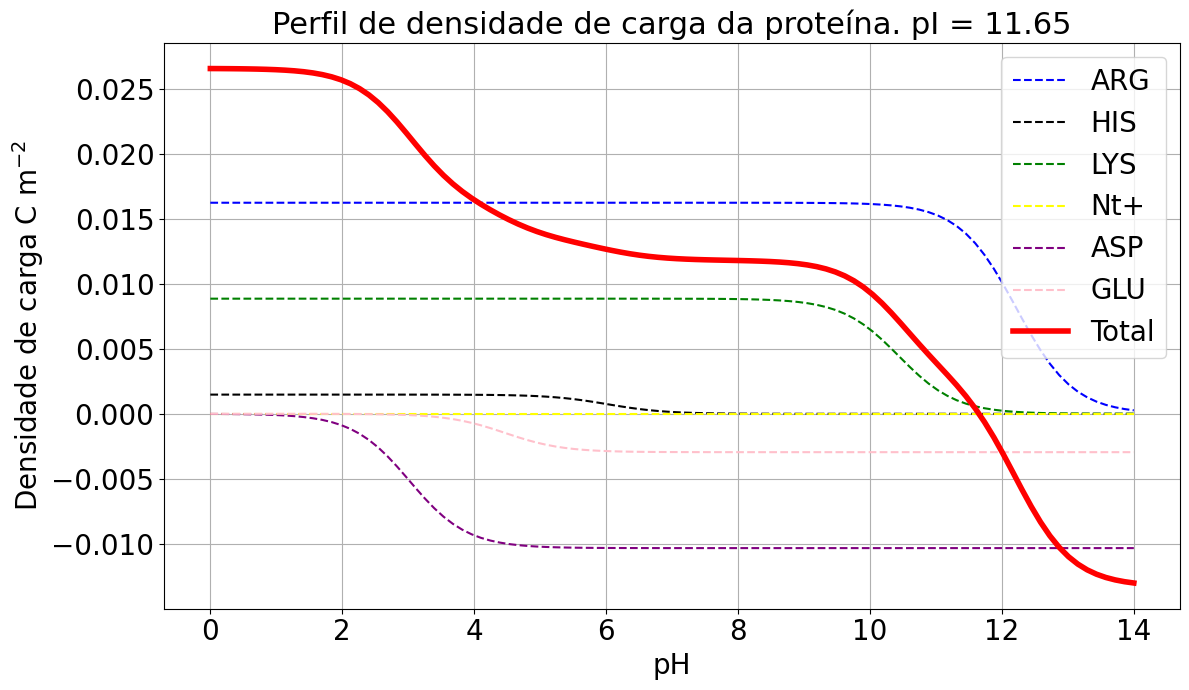

In [42]:
# Plot do perfil da densidade de carga da proteína

pH_plot = np.linspace(0,14,100)

plt.rcParams["figure.figsize"] = [12.00, 7.00]
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["figure.autolayout"] = True
plt.xticks(fontsize=20)
plt.xlabel('pH', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Densidade de carga C m$^{-2}$', fontsize=20)


# Curvas para cada grupo de aminoácidos
plt.plot(pH_plot, sigma(pH_plot, 0), color = 'blue',   linestyle='dashed', label = 'ARG')
plt.plot(pH_plot, sigma(pH_plot, 1), color = 'black',  linestyle='dashed', label = 'HIS')
plt.plot(pH_plot, sigma(pH_plot, 2), color = 'green',  linestyle='dashed', label = 'LYS')
plt.plot(pH_plot, sigma(pH_plot, 3), color = 'yellow', linestyle='dashed', label = 'Nt+')
plt.plot(pH_plot, sigma(pH_plot, 4), color = 'purple', linestyle='dashed', label = 'ASP')
plt.plot(pH_plot, sigma(pH_plot, 5), color = 'pink',   linestyle='dashed', label = 'GLU')

# Perfil de densidade de carga após somar todas as curvas de densidade de cada grupo
plt.plot(pH_plot, sigma_pg(pH_plot), color = 'red', label = 'Total',linewidth=4.0)

plt.title('Perfil de densidade de carga da proteína. pI = {:,.2f}'.format(np.squeeze(fsolve(sigma_pg,8))), fontsize=22)
plt.legend()
plt.grid()
plt.show()


In [23]:
def kappa (Conc):

  kappa = np.sqrt(np.power(e,2)*Na*float(2)*Conc*float(1000)/epsilon/epsilon0/kb/T)

  return kappa

In [31]:
def carga (pH, sigma_classe):

  pw    = np.where(sigma_classe > 3, -1, 1)
  pd    = np.where(sigma_classe < 6, (e/4.0/np.pi/epsilon/epsilon0/rp/(kappa(C0)*rp + 1)), F)

  sigma = pw * (pd) * float((vect[sigma_classe,1])) / (1 + np.power( np.power(10.0,pH-float((vect[sigma_classe,0])) ),pw) )

  return sigma

def zeta (pH):

  zeta_0 = 0.0
  for i in range(0, np.size(vect,axis=0)-1):
    zeta_0 += carga(pH, i)

  return zeta_0*1000

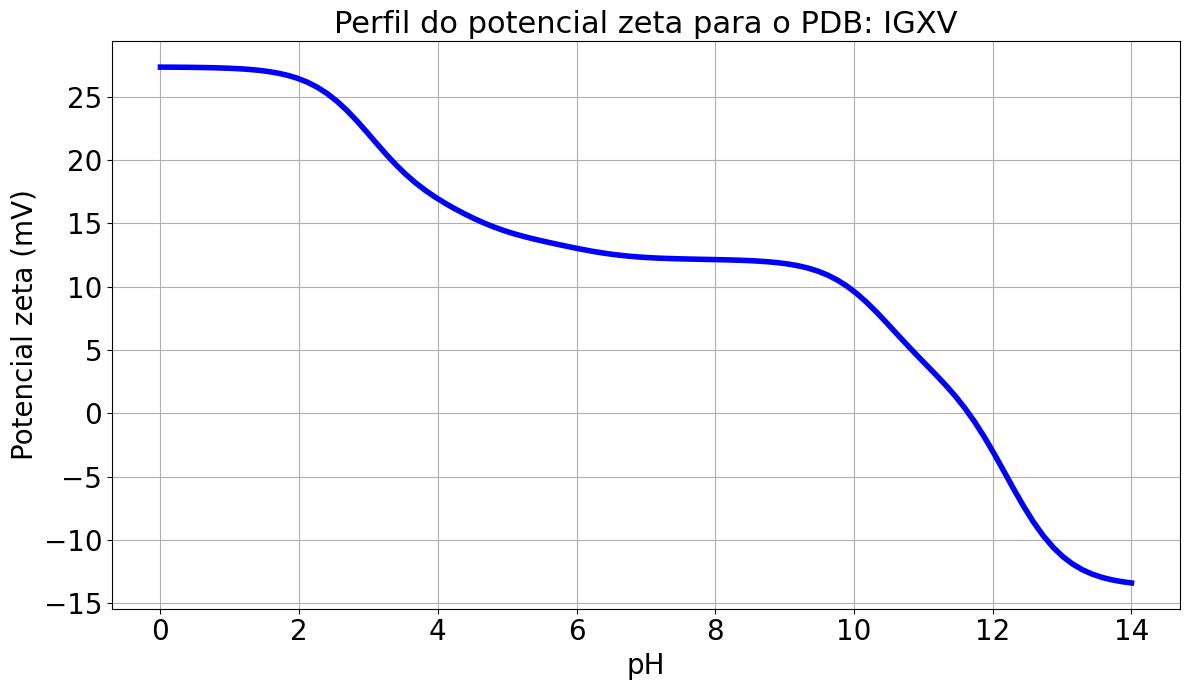

In [37]:
# Plot do perfil da densidade de carga do adsorvente

pH_plot = np.linspace(0,14,100)

plt.rcParams["figure.figsize"] = [12.00, 7.00]
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["figure.autolayout"] = True
plt.xticks(fontsize=20)
plt.xlabel('pH', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Potencial zeta (mV)', fontsize=20)

plt.plot(pH_plot, zeta(pH_plot), color = 'blue',linewidth=4.0)

plt.title('Perfil do potencial zeta para o PDB: ' + PDB, fontsize=22)
plt.grid()
plt.show()

In [39]:
A = zeta(pH_plot)
B = pH_plot

In [41]:
np.savetxt("Data_Henry.txt", np.array([B, A]).T)